## Setup

We'll use the Optimism public RPC to query transaction data. For more comprehensive data, you can use an Alchemy or Infura API key.

In [ ]:
import os
from datetime import datetime
from dotenv import load_dotenv
import pandas as pd
import requests
from web3 import Web3

# Load environment variables
load_dotenv()

# Configuration
ATTACKER_ADDRESS = "0x8B6B008A0073D34D04ff00210E7200Ab00003300"
CONTRACT_ADDRESS = "0x80f95d330417a4acEfEA415FE9eE28db7A0A1Cdb"
MY_ADDRESS = "0x073f26f0c3fc100e7b075c3dc3cde0a777497d20"

# Optimism RPC - use Alchemy if available, otherwise public RPC
ALCHEMY_API_KEY = os.getenv("ALCHEMY_API_KEY", "")
if ALCHEMY_API_KEY:
    OPTIMISM_RPC = f"https://opt-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
else:
    OPTIMISM_RPC = "https://mainnet.optimism.io"

# Optimistic Etherscan API (optional, for more detailed tx history)
ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_API_KEY", "")

print(f"🎯 Target Contract: {CONTRACT_ADDRESS}")
print(f"🔴 Attacker Wallet: {ATTACKER_ADDRESS}")
print(f"🌐 RPC: {'Alchemy' if ALCHEMY_API_KEY else 'Public Optimism RPC'}")
print(f"📊 Etherscan API: {'Available' if ETHERSCAN_API_KEY else 'Not configured'}")

52JSW14NRHTUQ8JVRM9GFNIB3T59X5JKRQ
🎯 Target Contract: 0x80f95d330417a4acEfEA415FE9eE28db7A0A1Cdb
🔴 Attacker Wallet: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
🌐 RPC: Alchemy
📊 Etherscan API: Available


## Connect to Optimism

In [4]:
# Connect to Optimism
w3 = Web3(Web3.HTTPProvider(OPTIMISM_RPC))

if w3.is_connected():
    print(f"✅ Connected to Optimism")
    print(f"📦 Latest block: {w3.eth.block_number}")
    print(f"⛓️  Chain ID: {w3.eth.chain_id}")
else:
    print("❌ Failed to connect to Optimism")

✅ Connected to Optimism
📦 Latest block: 144442944
⛓️  Chain ID: 10


## GenImNFT Contract ABI (relevant functions)

We only need the function signatures for the exploit analysis.

In [50]:
# Minimal ABI for the functions we're analyzing
GENIMG_ABI = [
    {
        "name": "requestImageUpdate",
        "type": "function",
        "inputs": [
            {"name": "tokenId", "type": "uint256"},
            {"name": "newImageUrl", "type": "string"}
        ],
        "outputs": []
    },
    {
        "name": "mintPrice",
        "type": "function",
        "inputs": [],
        "outputs": [{"name": "", "type": "uint256"}]
    },
    {
        "name": "ImageUpdateRequested",
        "type": "event",
        "inputs": [
            {"name": "tokenId", "type": "uint256", "indexed": True},
            {"name": "requester", "type": "address", "indexed": True},
            {"name": "newImageUrl", "type": "string", "indexed": False}
        ]
    },
    {
        "name": "Transfer",
        "type": "event",
        "inputs": [
            {"name": "from", "type": "address", "indexed": True},
            {"name": "to", "type": "address", "indexed": True},
            {"name": "tokenId", "type": "uint256", "indexed": True}
        ]
    }
]

# Create contract instance
contract = w3.eth.contract(
    address=Web3.to_checksum_address(CONTRACT_ADDRESS),
    abi=GENIMG_ABI
)

# Get function signature for requestImageUpdate
REQUEST_IMAGE_UPDATE_SIG = w3.keccak(text="requestImageUpdate(uint256,string)")[:4].hex()
print(f"📝 requestImageUpdate signature: 0x{REQUEST_IMAGE_UPDATE_SIG}")

📝 requestImageUpdate signature: 0x9f42ba30


In [22]:
def get_all_transactions(address: str, max_count: int = 100) -> pd.DataFrame:
    """
    Fetch all transactions FROM an address using Alchemy API.
    
    Args:
        address: The wallet address to query
        max_count: Maximum number of transactions to fetch (default 100)
    
    Returns:
        DataFrame with transaction details
    """
    if not ALCHEMY_API_KEY:
        print("❌ No ALCHEMY_API_KEY set in .env")
        return pd.DataFrame()
    
    url = f"https://opt-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
    
    # Get all transactions FROM the address
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "alchemy_getAssetTransfers",
        "params": [{
            "fromAddress": address,
            "category": ["external", "erc20", "erc721"],
            "withMetadata": True,
            "order": "desc",
            "maxCount": hex(max_count)
        }]
    }
    
    print(f"🔍 Fetching transactions from: {address}")
    response = requests.post(url, json=payload)
    
    if response.status_code != 200:
        print(f"❌ HTTP Error: {response.status_code}")
        return pd.DataFrame()
    
    data = response.json()
    
    if "error" in data:
        print(f"❌ Alchemy Error: {data['error']}")
        return pd.DataFrame()
    
    transfers = data.get("result", {}).get("transfers", [])
    print(f"✅ Found {len(transfers)} transactions")
    
    if not transfers:
        return pd.DataFrame()
    
    # Convert to DataFrame
    rows = []
    for tx in transfers:
        rows.append({
            "hash": tx.get("hash"),
            "blockNum": int(tx.get("blockNum"), 16),
            "timestamp": tx.get("metadata", {}).get("blockTimestamp"),
            "from": tx.get("from"),
            "to": tx.get("to"),
            "value": float(tx.get("value", 0) or 0),
            "asset": tx.get("asset"),
            "category": tx.get("category")
        })
    
    df = pd.DataFrame(rows)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    
    return df

# Test with your address
my_txs = get_all_transactions(MY_ADDRESS, max_count=20)

if not my_txs.empty:
    print(f"\n📋 Your recent transactions:")
    display(my_txs)

🔍 Fetching transactions from: 0x073f26f0c3fc100e7b075c3dc3cde0a777497d20
✅ Found 20 transactions
✅ Found 20 transactions

📋 Your recent transactions:

📋 Your recent transactions:


,hash,blockNum,timestamp,from,to,value,asset,category
0,0xfa82a11b961f957c95ddece0ab0a627e26f991641888...,144358019,2025-11-28 07:26:55+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x0000000000000000000000000000000000000000,0.00000,None,erc721
1,0x058061f36ac0876540661449b05ff5f9bb2214631d24...,144357999,2025-11-28 07:26:15+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
2,0x3b2762e72904212a7608904eb50cdcf57379f283322e...,144357966,2025-11-28 07:25:09+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
3,0x572b64b69a924182733ac4efd607c2ac7e988a6841e3...,144357536,2025-11-28 07:10:49+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
4,0x7fd95df3a080b89aed334178887381cf4aaaf1429d43...,144270851,2025-11-26 07:01:19+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
5,0xe71115e8972da6ffe38d1fdb1bdb57db30eccf4bc218...,144270317,2025-11-26 06:43:31+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
6,0x4a94eb1095f1543d0efbf5a7208e4b3f40ca8d9cc028...,144209862,2025-11-24 21:08:21+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
7,0xe0e1900f768f2166237d6686606e6aad04c1591d1a99...,144209545,2025-11-24 20:57:47+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
8,0x62bbcb77fcaa06a979020792882b3e17e97005c71205...,144209536,2025-11-24 20:57:29+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external
9,0xa0aa9b6d57dd410af7e6ab08ab5353150ff26e2829e4...,144209519,2025-11-24 20:56:55+00:00,0x073f26f0c3fc100e7b075c3dc3cde0a777497d20,0x80f95d330417a4acefea415fe9ee28db7a0a1cdb,0.00002,ETH,external


In [62]:
# Better approach: Query the ImageUpdateRequested events from the contract
# Using PUBLIC Optimism RPC which allows larger block ranges than Alchemy Free Tier

print("🔍 Querying ImageUpdateRequested events from contract...")
print("=" * 60)

# Use public Optimism RPC for getLogs (allows larger ranges)
public_w3 = Web3(Web3.HTTPProvider("https://mainnet.optimism.io"))

# Get ImageUpdateRequested events
event_sig = public_w3.keccak(text="ImageUpdateRequested(uint256,address,string)")
print(f"Event topic: 0x{event_sig.hex()}")

# Query using public RPC with larger chunks
latest_block = public_w3.eth.block_number
chunk_size = 2000  # Public RPC allows larger ranges
total_blocks_to_scan = 500000  # ~20 days on Optimism

all_events = []

print(f"\n📦 Scanning {total_blocks_to_scan} blocks in chunks of {chunk_size}...")
print(f"   From block: {latest_block - total_blocks_to_scan}")
print(f"   To block: {latest_block}")
print()

total_chunks = total_blocks_to_scan // chunk_size
processed = 0

for start in range(latest_block - total_blocks_to_scan, latest_block, chunk_size):
    end = min(start + chunk_size - 1, latest_block)
    processed += 1
    
    try:
        logs = public_w3.eth.get_logs({
            "address": Web3.to_checksum_address(CONTRACT_ADDRESS),
            "topics": [event_sig],
            "fromBlock": start,
            "toBlock": end
        })
        
        if logs:
            all_events.extend(logs)
            print(f"   ✅ Block {start}-{end}: Found {len(logs)} events")
            
    except Exception as e:
        error_msg = str(e)
        if "block range" in error_msg.lower():
            print(f"   ⚠️  Block range too large, trying smaller chunks...")
            # Try smaller chunks if range too large
            for sub_start in range(start, end, 500):
                sub_end = min(sub_start + 499, end)
                try:
                    sub_logs = public_w3.eth.get_logs({
                        "address": Web3.to_checksum_address(CONTRACT_ADDRESS),
                        "topics": [event_sig],
                        "fromBlock": sub_start,
                        "toBlock": sub_end
                    })
                    if sub_logs:
                        all_events.extend(sub_logs)
                        print(f"      ✅ Block {sub_start}-{sub_end}: Found {len(sub_logs)} events")
                except Exception as sub_e:
                    print(f"      ❌ Block {sub_start}-{sub_end}: {sub_e}")
        else:
            print(f"   ❌ Block {start}-{end}: {e}")
    
    # Progress update every 50 chunks
    if processed % 50 == 0:
        print(f"   📊 Progress: {processed}/{total_chunks} chunks ({100*processed/total_chunks:.1f}%), Events so far: {len(all_events)}")

print(f"\n✅ Total events found: {len(all_events)}")

if all_events:
    events_data = []
    for log in all_events:
        token_id = int(log["topics"][1].hex(), 16)
        requester = "0x" + log["topics"][2].hex()[-40:]
        
        events_data.append({
            "blockNumber": log["blockNumber"],
            "transactionHash": log["transactionHash"].hex(),
            "tokenId": token_id,
            "requester": requester.lower(),
            "is_attacker": requester.lower() == ATTACKER_ADDRESS.lower()
        })
    
    events_df = pd.DataFrame(events_data)
    
    # Show attacker's events
    attacker_events = events_df[events_df["is_attacker"]]
    print(f"\n🔴 Events from ATTACKER: {len(attacker_events)}")
    if not attacker_events.empty:
        display(attacker_events.head(20))
        
        # Calculate stolen amount
        num_attacks = len(attacker_events)
        stolen_eth = num_attacks * mint_price_eth
        print(f"\n💸 Estimated stolen: {num_attacks} × {mint_price_eth} ETH = {stolen_eth:.6f} ETH")
    
    # Show other requesters
    other_events = events_df[~events_df["is_attacker"]]
    print(f"\n✅ Events from OTHER users: {len(other_events)}")
    
    # Summary by requester
    print(f"\n📊 Summary by requester:")
    requester_summary = events_df.groupby("requester").agg({
        "transactionHash": "count",
        "is_attacker": "first"
    }).rename(columns={"transactionHash": "event_count"})
    requester_summary = requester_summary.sort_values("event_count", ascending=False)
    display(requester_summary)
else:
    print("No ImageUpdateRequested events found in the scanned block range.")
    print("\n💡 The contract may be new or have no requestImageUpdate calls yet.")

🔍 Querying ImageUpdateRequested events from contract...
Event topic: 0x9c5aec7f143040caecc06c378c9f67b2539c1516233c0769598c2a7db4316cee

📦 Scanning 500000 blocks in chunks of 2000...
   From block: 143921722
   To block: 144421722


📦 Scanning 500000 blocks in chunks of 2000...
   From block: 143921722
   To block: 144421722

   📊 Progress: 50/250 chunks (20.0%), Events so far: 0
   📊 Progress: 50/250 chunks (20.0%), Events so far: 0
   📊 Progress: 100/250 chunks (40.0%), Events so far: 0
   📊 Progress: 100/250 chunks (40.0%), Events so far: 0
   ✅ Block 144205722-144207721: Found 1 events
   ✅ Block 144205722-144207721: Found 1 events
   ✅ Block 144207722-144209721: Found 12 events
   ✅ Block 144207722-144209721: Found 12 events
   ✅ Block 144209722-144211721: Found 1 events
   ✅ Block 144209722-144211721: Found 1 events
   📊 Progress: 150/250 chunks (60.0%), Events so far: 14
   📊 Progress: 150/250 chunks (60.0%), Events so far: 14
   ✅ Block 144269722-144271721: Found 2 events
   ✅ 

,blockNumber,transactionHash,tokenId,requester,is_attacker
0,144207649,4165d84f1fac193b5e2ef8ed019a0ba0bcef2c0f19d8b7...,142,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
1,144207727,d3edb67c036ac2ce7e0ec7009c16250226593dd720f39a...,143,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
2,144207761,d1a106a7744f77fd567f5b21d4999204960ecc9637749b...,144,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
3,144207995,5414ced57b001455c314b911268ec0b82b5b3958684d22...,145,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
4,144208124,7512fbd1e6ad70de8d836929e757fe7e944db6483c0bc2...,146,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
5,144208191,6d5245c934d43576611990d83c1da018143b9871514282...,147,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
6,144208455,3293aa258560b1a1fd43ea64a2b66302b82a109767a2f7...,148,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
7,144208645,5f02f1b3410933817f47c67f687eb7a840e2c6306b7bdf...,149,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
8,144208788,f650d4f488d14913dd94a7a21650339d2d7ee598ea4d77...,150,0x8b6b008a0073d34d04ff00210e7200ab00003300,True
9,144209405,fcf02e62ca4604e495587fc86ff11643102556ecfde495...,151,0x8b6b008a0073d34d04ff00210e7200ab00003300,True



💸 Estimated stolen: 16 × 2e-05 ETH = 0.000320 ETH

✅ Events from OTHER users: 1

📊 Summary by requester:


,event_count,is_attacker
requester,,
0x8b6b008a0073d34d04ff00210e7200ab00003300,16,True
0xaaebc1441323b8ad6bdf6793a8428166b510239c,1,False


In [63]:
# Analyze the attack events we found
print("🔴 Attack Analysis from Events")
print("=" * 60)

if 'events_df' in dir() and not events_df.empty:
    # Get attacker events
    attacker_events_df = events_df[events_df["is_attacker"]].copy()
    
    if not attacker_events_df.empty:
        print(f"\n📊 Attacker Statistics:")
        print(f"   Total attacks: {len(attacker_events_df)}")
        print(f"   Unique tokens targeted: {attacker_events_df['tokenId'].nunique()}")
        print(f"   Block range: {attacker_events_df['blockNumber'].min()} - {attacker_events_df['blockNumber'].max()}")
        
        # Calculate stolen ETH
        stolen_eth = len(attacker_events_df) * mint_price_eth
        print(f"\n💸 Estimated Stolen Funds:")
        print(f"   Attacks: {len(attacker_events_df)}")
        print(f"   ETH per attack: {mint_price_eth} ETH")
        print(f"   Total stolen: {stolen_eth:.6f} ETH")
        
        # Get timestamps for each attack by fetching block info
        print(f"\n⏱️  Fetching timestamps for attack transactions...")
        
        timestamps = []
        for _, row in attacker_events_df.iterrows():
            try:
                block = public_w3.eth.get_block(row["blockNumber"])
                timestamps.append(datetime.fromtimestamp(block["timestamp"]))
            except:
                timestamps.append(None)
        
        attacker_events_df["timestamp"] = timestamps
        
        print(f"\n📋 All {len(attacker_events_df)} Attack Transactions:")
        display(attacker_events_df)
        
        # Timeline
        if attacker_events_df["timestamp"].notna().any():
            print(f"\n⏰ Attack Timeline:")
            print(f"   First attack: {attacker_events_df['timestamp'].min()}")
            print(f"   Last attack: {attacker_events_df['timestamp'].max()}")
            
            # Attacks per day
            attacker_events_df["date"] = attacker_events_df["timestamp"].dt.date
            attacks_per_day = attacker_events_df.groupby("date").size()
            print(f"\n📅 Attacks per day:")
            for date, count in attacks_per_day.items():
                print(f"   {date}: {count} attacks")
        
        # Most targeted tokens
        print(f"\n🎯 Most targeted tokens:")
        token_counts = attacker_events_df["tokenId"].value_counts().head(10)
        for token_id, count in token_counts.items():
            print(f"   Token #{token_id}: {count} attacks")
        
        # Save attack data
        attack_df = attacker_events_df  # For compatibility with later cells
        
    else:
        print("No attacks from the identified attacker found.")
        
    # Show legitimate users
    other_events_df = events_df[~events_df["is_attacker"]]
    if not other_events_df.empty:
        print(f"\n✅ Legitimate Users ({len(other_events_df)} events):")
        for requester in other_events_df["requester"].unique():
            count = len(other_events_df[other_events_df["requester"] == requester])
            print(f"   {requester[:20]}...: {count} requests")
else:
    print("❌ No events_df available. Run the event query cell first.")

🔴 Attack Analysis from Events

📊 Attacker Statistics:
   Total attacks: 16
   Unique tokens targeted: 16
   Block range: 144207649 - 144270852

💸 Estimated Stolen Funds:
   Attacks: 16
   ETH per attack: 2e-05 ETH
   Total stolen: 0.000320 ETH

⏱️  Fetching timestamps for attack transactions...

📋 All 16 Attack Transactions:


,blockNumber,transactionHash,tokenId,requester,is_attacker,timestamp
0,144207649,4165d84f1fac193b5e2ef8ed019a0ba0bcef2c0f19d8b7...,142,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 20:54:35
1,144207727,d3edb67c036ac2ce7e0ec7009c16250226593dd720f39a...,143,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 20:57:11
2,144207761,d1a106a7744f77fd567f5b21d4999204960ecc9637749b...,144,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 20:58:19
3,144207995,5414ced57b001455c314b911268ec0b82b5b3958684d22...,145,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:06:07
4,144208124,7512fbd1e6ad70de8d836929e757fe7e944db6483c0bc2...,146,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:10:25
5,144208191,6d5245c934d43576611990d83c1da018143b9871514282...,147,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:12:39
6,144208455,3293aa258560b1a1fd43ea64a2b66302b82a109767a2f7...,148,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:21:27
7,144208645,5f02f1b3410933817f47c67f687eb7a840e2c6306b7bdf...,149,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:27:47
8,144208788,f650d4f488d14913dd94a7a21650339d2d7ee598ea4d77...,150,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:32:33
9,144209405,fcf02e62ca4604e495587fc86ff11643102556ecfde495...,151,0x8b6b008a0073d34d04ff00210e7200ab00003300,True,2025-11-24 21:53:07



⏰ Attack Timeline:
   First attack: 2025-11-24 20:54:35
   Last attack: 2025-11-26 08:01:21

📅 Attacks per day:
   2025-11-24: 14 attacks
   2025-11-26: 2 attacks

🎯 Most targeted tokens:
   Token #142: 1 attacks
   Token #143: 1 attacks
   Token #144: 1 attacks
   Token #145: 1 attacks
   Token #146: 1 attacks
   Token #147: 1 attacks
   Token #148: 1 attacks
   Token #149: 1 attacks
   Token #150: 1 attacks
   Token #151: 1 attacks

✅ Legitimate Users (1 events):
   0xaaebc1441323b8ad6b...: 1 requests


## Attacker Wallet Analysis

Analyze the attacker's wallet for additional context.

In [64]:
# Get attacker wallet info
attacker_checksum = Web3.to_checksum_address(ATTACKER_ADDRESS)

balance = w3.eth.get_balance(attacker_checksum)
balance_eth = balance / 1e18

tx_count = w3.eth.get_transaction_count(attacker_checksum)

print(f"🔴 Attacker Wallet Analysis")
print(f"=" * 50)
print(f"Address: {ATTACKER_ADDRESS}")
print(f"Current Balance: {balance_eth:.6f} ETH")
print(f"Total Transactions: {tx_count}")
print(f"")
print(f"🔗 View on Optimistic Etherscan:")
print(f"   https://optimistic.etherscan.io/address/{ATTACKER_ADDRESS}")

🔴 Attacker Wallet Analysis
Address: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
Current Balance: 0.001616 ETH
Total Transactions: 364

🔗 View on Optimistic Etherscan:
   https://optimistic.etherscan.io/address/0x8B6B008A0073D34D04ff00210E7200Ab00003300


# Fund tracing

In [23]:
# Fund Tracing: Where did the attacker move the funds?
print("💰 Fund Tracing Analysis")
print("=" * 60)

# Known addresses for CEX/Bridges on Optimism
KNOWN_ADDRESSES = {
    "0x89e51fa8ca5d66cd220baed62ed01e8951aa7c40": "Binance",
    "0x4200000000000000000000000000000000000010": "Optimism L1 Bridge",
    "0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45": "Uniswap V3 Router",
    "0x1111111254eeb25477b68fb85ed929f73a960582": "1inch Router",
}

def get_transactions_to_address(address: str, max_count: int = 100) -> pd.DataFrame:
    """Fetch transactions TO an address"""
    if not ALCHEMY_API_KEY:
        return pd.DataFrame()
    url = f"https://opt-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
    payload = {"jsonrpc": "2.0", "id": 1, "method": "alchemy_getAssetTransfers",
               "params": [{"toAddress": address, "category": ["external", "erc20", "erc721"],
                          "withMetadata": True, "order": "desc", "maxCount": hex(max_count)}]}
    response = requests.post(url, json=payload)
    data = response.json()
    if "error" in data or not data.get("result", {}).get("transfers"):
        return pd.DataFrame()
    rows = [{"hash": tx["hash"], "timestamp": pd.to_datetime(tx["metadata"]["blockTimestamp"]),
             "from": tx["from"], "to": tx["to"], "value": float(tx.get("value", 0) or 0),
             "asset": tx.get("asset")} for tx in data["result"]["transfers"]]
    return pd.DataFrame(rows)

# Get outgoing transactions
outgoing_txs = get_all_transactions(ATTACKER_ADDRESS, max_count=500)

if not outgoing_txs.empty:
    print(f"\n✅ {len(outgoing_txs)} outgoing transactions")
    
    # Summarize by destination
    summary = []
    for to_addr in outgoing_txs["to"].unique():
        subset = outgoing_txs[outgoing_txs["to"] == to_addr]
        known = KNOWN_ADDRESSES.get(to_addr.lower()) if to_addr else None
        is_self = to_addr and to_addr.lower() == ATTACKER_ADDRESS.lower()
        summary.append({
            "address": to_addr[:20] + "..." if to_addr else "None",
            "known_as": known or ("Self" if is_self else "Unknown"),
            "tx_count": len(subset),
            "total_value": subset["value"].sum(),
            "assets": list(subset["asset"].unique())
        })
    
    dest_df = pd.DataFrame(summary).sort_values("total_value", ascending=False)
    display(dest_df.head(10))
    
    # Key findings
    self_txs = dest_df[dest_df["known_as"] == "Self"]
    unknown_txs = dest_df[dest_df["known_as"] == "Unknown"]
    
    print(f"\n📊 Summary:")
    print(f"   Self-transfers: {len(self_txs)} destinations, {self_txs['tx_count'].sum()} txs")
    print(f"   Unknown destinations: {len(unknown_txs)} addresses")
    
    if not unknown_txs.empty:
        print(f"\n❓ Unknown destinations (potential accomplices):")
        for _, row in unknown_txs.head(5).iterrows():
            print(f"   {row['address']} | {row['total_value']:.4f} | {row['assets']}")

💰 Fund Tracing Analysis
🔍 Fetching transactions from: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
✅ Found 360 transactions

✅ 360 outgoing transactions
✅ Found 360 transactions

✅ 360 outgoing transactions


,address,known_as,tx_count,total_value,assets
2,0xda60f6f99cea7fb4ac...,Unknown,2,3.985313e+01,"[USDC, sUSD]"
1,0xda60192af08b0564fd...,Unknown,1,1.983040e+01,[UЅDC.e]
0,0x8b6b008a0073d34d04...,Self,357,2.383100e-10,[ETH]



📊 Summary:
   Self-transfers: 1 destinations, 357 txs
   Unknown destinations: 2 addresses

❓ Unknown destinations (potential accomplices):
   0xda60f6f99cea7fb4ac... | 39.8531 | ['USDC', 'sUSD']
   0xda60192af08b0564fd... | 19.8304 | ['UЅDC.e']


In [ ]:
# Funding Sources: Where did the attacker get funds from?
print("💵 Funding Source Analysis")
print("=" * 60)

incoming_txs = get_transactions_to_address(ATTACKER_ADDRESS, max_count=100)

if not incoming_txs.empty:
    print(f"\n✅ {len(incoming_txs)} incoming transactions")
    
    # Summarize by source
    summary = []
    for from_addr in incoming_txs["from"].unique():
        subset = incoming_txs[incoming_txs["from"] == from_addr]
        known = KNOWN_ADDRESSES.get(from_addr.lower()) if from_addr else None
        summary.append({
            "address": from_addr[:20] + "..." if from_addr else "None",
            "known_as": known or "Unknown",
            "tx_count": len(subset),
            "total_value": subset["value"].sum(),
            "assets": list(subset["asset"].unique()),
            "first_tx": subset["timestamp"].min()
        })
    
    source_df = pd.DataFrame(summary).sort_values("total_value", ascending=False)
    display(source_df)
    
    # Key findings
    cex_funding = source_df[source_df["known_as"].str.contains("Binance|Bybit|OKX", na=False, case=False)]
    if not cex_funding.empty:
        print(f"\n🏦 CEX Funding (TRACEABLE):")
        for _, row in cex_funding.iterrows():
            print(f"   {row['known_as']}: {row['total_value']:.6f} ETH")
else:
    print("❌ No incoming transactions found (may be funded via internal txs)")

💵 Funding Source Analysis

✅ Found 921 incoming transactions

📥 Funding Sources:
------------------------------------------------------------

✅ Found 921 incoming transactions

📥 Funding Sources:
------------------------------------------------------------


,address,known_as,tx_count,total_value,assets,first_tx,last_tx
19,0xd152f549545093347a162dce210e7293f1452150,Unknown,1,1.000000e+03,[WLFI],2025-11-03 07:56:21+00:00,2025-11-03 07:56:21+00:00
22,0x6adaa3eba85c77e8566b73aefb4c2f39df4046ca,Unknown,2,4.000000e+01,[GRAI],2025-11-02 02:42:31+00:00,2025-11-02 02:42:31+00:00
25,0x93fc04cd6d108588ecd844c7d60f46635037b5a3,Unknown,2,3.985313e+01,"[sUSD, USDC]",2025-10-30 03:48:05+00:00,2025-10-30 03:48:05+00:00
1,0xec16bd5874a10e5c171810fea8d7f6c9236a55b2,Unknown,39,3.393174e+01,[VELO],2025-10-25 10:18:27+00:00,2025-11-29 07:30:41+00:00
24,0x3327c272562f8a1a530c4419b8b33b3f3537b5a3,Unknown,1,1.983040e+01,[UЅDC.e],2025-10-30 03:52:35+00:00,2025-10-30 03:52:35+00:00
16,0xe21328bd90de1433f99512608558ff9481d94be2,Unknown,3,8.174889e+00,[USDC],2025-11-05 06:18:13+00:00,2025-11-06 06:06:05+00:00
18,0xc6249f4e0df56474165eb2d95d53941f54d94be2,Unknown,1,4.503572e+00,[UЅDС],2025-11-05 07:18:41+00:00,2025-11-05 07:18:41+00:00
7,0x1d68fc7c741a9e7ea1ffa447ef5230d917fc244f,Unknown,1,1.283224e+00,[WCT],2025-11-20 01:55:35+00:00,2025-11-20 01:55:35+00:00
12,0x7e3cb178e9857b53b1c41e34d5997c6e3774cf2c,Unknown,1,6.027034e-01,[VELO],2025-11-09 22:58:49+00:00,2025-11-09 22:58:49+00:00
2,0x8c864d0c8e476bf9eb9d620c10e1296fb0e2f940,Unknown,429,1.310063e-01,"[WETH, WBTC, USDC, USDT, OP, WLD]",2025-10-23 00:35:57+00:00,2025-11-28 23:41:49+00:00



🔍 Key Findings:
------------------------------------------------------------

❓ Unknown Funding Sources (investigate further):
   0xd152f549545093347a162dce210e7293f1452150
   Value: 1000.000000 ETH, Txs: 1
   First: 2025-11-03 07:56:21+00:00, Last: 2025-11-03 07:56:21+00:00
   0x6adaa3eba85c77e8566b73aefb4c2f39df4046ca
   Value: 40.000000 ETH, Txs: 2
   First: 2025-11-02 02:42:31+00:00, Last: 2025-11-02 02:42:31+00:00
   0x93fc04cd6d108588ecd844c7d60f46635037b5a3
   Value: 39.853135 ETH, Txs: 2
   First: 2025-10-30 03:48:05+00:00, Last: 2025-10-30 03:48:05+00:00
   0xec16bd5874a10e5c171810fea8d7f6c9236a55b2
   Value: 33.931741 ETH, Txs: 39
   First: 2025-10-25 10:18:27+00:00, Last: 2025-11-29 07:30:41+00:00
   0x3327c272562f8a1a530c4419b8b33b3f3537b5a3
   Value: 19.830403 ETH, Txs: 1
   First: 2025-10-30 03:52:35+00:00, Last: 2025-10-30 03:52:35+00:00
   0xe21328bd90de1433f99512608558ff9481d94be2
   Value: 8.174889 ETH, Txs: 3
   First: 2025-11-05 06:18:13+00:00, Last: 2025-11-06 06:

In [ ]:
# Verify if the attacker address is a Smart Contract
print("🔍 Is the Attacker Address a Smart Contract?")
print("=" * 70)

DELEGATE_ADDRESS = "0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820"
attacker_checksum = Web3.to_checksum_address(ATTACKER_ADDRESS)

# Get code at address
code = w3.eth.get_code(attacker_checksum)

if len(code) > 0:
    print(f"\n✅ YES! The address has bytecode ({len(code)} bytes)")
    print(f"   First 50 bytes: {code[:50].hex()}")
    
    # Check for ERC-7702 pattern (ef0100 prefix + delegate address)
    if code[:2].hex() == "ef01":
        delegate_addr = "0x" + code[3:23].hex()
        print(f"\n🚨 ERC-7702 DELEGATED EOA DETECTED!")
        print(f"   → This is an EOA that delegated code execution to:")
        print(f"   → {delegate_addr}")
        print(f"\n   Meaning: The REAL attacker owns the private key to {ATTACKER_ADDRESS[:15]}...")
    else:
        print(f"\n   This is a regular Smart Contract")
else:
    print(f"\n❌ No bytecode - this is a regular EOA")

# Check the delegate/bot implementation
print(f"\n" + "-" * 70)
print(f"🔍 Bot Implementation: {DELEGATE_ADDRESS}")

delegate_code = w3.eth.get_code(Web3.to_checksum_address(DELEGATE_ADDRESS))
print(f"   Bytecode Length: {len(delegate_code)} bytes")
print(f"   → This is the MEV bot code that gets executed")

🔍 Ist die Attacker-Adresse ein Smart Contract?

✅ JA! Die Adresse ist ein SMART CONTRACT!
   Bytecode Länge: 23 bytes
   Bytecode (first 100 bytes): ef01003ecc9f049c569e59a2de5b3a51bc7b8a94225820

🤖 Interpretation:
   - Dies ist ein Smart Contract Wallet (SCW)
   - Wahrscheinlich ein ERC-4337 Account oder ähnlich
   - Der OWNER des Contracts ist der echte Angreifer
   - Die 'Self-Transfers' sind execute() Aufrufe an diesen Contract

----------------------------------------------------------------------
🔍 Ist die Delegate-Adresse ein Smart Contract?

✅ JA! Delegate ist auch ein Smart Contract!
   Bytecode Länge: 1118 bytes

🔑 Versuche den Owner des Attacker-Contracts zu finden...
----------------------------------------------------------------------
   owner(): 0x8B6B008A0073D34D04ff00210E7200Ab00003300
   admin(): 0x0000000000000000000000000000000000000001
   getOwner(): 0x8B6B008A0073D34D04ff00210E7200Ab00003300
   implementation(): 0x0000000000000000000000000000000000000001

🔍 Prüfe 

## 📋 Zusammenfassung der Forensik-Analyse

### Wichtigste Entdeckung: ERC-7702 Delegation

Die Angreifer-Adresse `0x8B6B...3300` ist ein **ERC-7702 Delegated EOA**:

```
Bytecode: ef0100 + 3ecc9f049c569e59a2de5b3a51bc7b8a94225820
         ^^^^^^   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
         Prefix   Bot Implementation Address
```

→ Der **echte Angreifer** besitzt den Private Key zu dieser Adresse und ist **unbekannt**.

### Angriffs-Statistik

| Metrik | Wert |
|--------|------|
| Angriffe | 16 (Token #142-#157) |
| Zeitraum | 24.-26. Nov 2025 |
| Gestohlener Betrag | ~0.00032 ETH |

### Netzwerk-Struktur

```
UNKNOWN OWNER → 0x8B6B...3300 (ERC-7702 EOA)
                      ↓ delegates to
                0x3ecC...5820 (MEV Bot Code)
                      ↓ attacks
                GenImNFT Contract
                      ↓ sends funds to
                0xda60f6... & 0xda60192... (Vanity addresses)
```

### Offene Fragen
1. Wer hat den Bot-Contract deployed?
2. Wer steht hinter den 0xda60... Vanity-Adressen?
3. Cross-chain Aktivität auf anderen L2s?

### Links
- [Attacker](https://optimistic.etherscan.io/address/0x8B6B008A0073D34D04ff00210E7200Ab00003300)
- [Bot Implementation](https://optimistic.etherscan.io/address/0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820)

In [5]:
# Cross-Chain Analyse: Prüfe die Adressen auf Ethereum Mainnet
print("🌐 Cross-Chain Analyse: Ethereum Mainnet")
print("=" * 70)

# Key addresses from the analysis
BOT_IMPLEMENTATION = "0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820"
RECIPIENT_1 = "0xda60f6f99cea7fb4acfb3dfcb817691eaa41ba4e"
RECIPIENT_2 = "0xda60192af08b0564fd0f0aab19072a9d4149ba4e"

# Etherscan v2 API - supports all chains with chainid parameter
ETHERSCAN_V2_URL = "https://api.etherscan.io/v2/api"
ADDRESSES_TO_CHECK = [
    ("Attacker", ATTACKER_ADDRESS),
    ("Bot Implementation", BOT_IMPLEMENTATION),
    ("Recipient 1", RECIPIENT_1),
    ("Recipient 2", RECIPIENT_2),
]

def check_address_mainnet(address: str, name: str) -> dict:
    """Check address on Ethereum Mainnet via Etherscan v2 API"""
    result = {"name": name, "address": address, "has_activity": False, "tx_count": 0, "balance_eth": 0}
    if not ETHERSCAN_API_KEY:
        return result
    
    # Get balance and transaction list
    for action, key in [("balance", "balance_eth"), ("txlist", "txs")]:
        params = {"chainid": 1, "module": "account", "action": action, 
                  "address": address, "apikey": ETHERSCAN_API_KEY}
        if action == "txlist":
            params.update({"startblock": 0, "endblock": 99999999, "page": 1, "offset": 20, "sort": "asc"})
        try:
            response = requests.get(ETHERSCAN_V2_URL, params=params)
            data = response.json()
            if data.get("status") == "1" and data.get("result"):
                if action == "balance":
                    result["balance_eth"] = int(data["result"]) / 1e18
                else:
                    result["txs"] = data["result"]
                    result["tx_count"] = len(data["result"])
                    result["has_activity"] = len(data["result"]) > 0
        except: pass
    return result

# Check all addresses on Mainnet
print("\n📍 Adressen auf Ethereum Mainnet prüfen:")
mainnet_results = []
for name, addr in ADDRESSES_TO_CHECK:
    result = check_address_mainnet(addr, name)
    mainnet_results.append(result)
    
    if result["has_activity"]:
        print(f"\n   ✅ {name}: {addr[:20]}...")
        print(f"      TX Count: {result['tx_count']}, Balance: {result['balance_eth']:.6f} ETH")
        if result.get("txs"):
            first = result["txs"][0]
            print(f"      First TX: {datetime.fromtimestamp(int(first['timeStamp']))}")
            print(f"      From: {first['from'][:20]}...")
            # Check for deployed contracts
            for tx in result["txs"]:
                if tx.get("to") == "" and tx.get("contractAddress"):
                    print(f"      🏭 Deployed: {tx['contractAddress']}")
    else:
        print(f"\n   ❌ {name}: Keine Aktivität auf Mainnet")

# Summary
print("\n" + "=" * 70)
print("📋 CROSS-CHAIN ZUSAMMENFASSUNG")
print("=" * 70)
active = [r for r in mainnet_results if r["has_activity"]]
print(f"\n   {len(active)}/{len(mainnet_results)} Adressen sind auf Ethereum Mainnet aktiv")

🌐 Cross-Chain Analyse: Ethereum Mainnet

📍 Adressen auf Ethereum Mainnet prüfen:

   ✅ Attacker: 0x8B6B008A0073D34D04...
      TX Count: 20, Balance: 1.607066 ETH
      First TX: 2025-10-22 14:04:47
      From: 0x5babe600b9fcd5fb7b...
      🏭 Deployed: 0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16

   ✅ Attacker: 0x8B6B008A0073D34D04...
      TX Count: 20, Balance: 1.607066 ETH
      First TX: 2025-10-22 14:04:47
      From: 0x5babe600b9fcd5fb7b...
      🏭 Deployed: 0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16

   ❌ Bot Implementation: Keine Aktivität auf Mainnet

   ❌ Bot Implementation: Keine Aktivität auf Mainnet

   ✅ Recipient 1: 0xda60f6f99cea7fb4ac...
      TX Count: 20, Balance: 0.037691 ETH
      First TX: 2021-07-29 21:50:07
      From: 0xddfabcdc4d8ffc6d5b...

   ✅ Recipient 1: 0xda60f6f99cea7fb4ac...
      TX Count: 20, Balance: 0.037691 ETH
      First TX: 2021-07-29 21:50:07
      From: 0xddfabcdc4d8ffc6d5b...

   ❌ Recipient 2: Keine Aktivität auf Mainnet

📋 CROSS-CHAIN ZUSAM

## 🕸️ Netzwerk-Visualisierung mit NetworkX

Visualisierung aller bekannten Wallet-Verbindungen als gerichteter Graph.

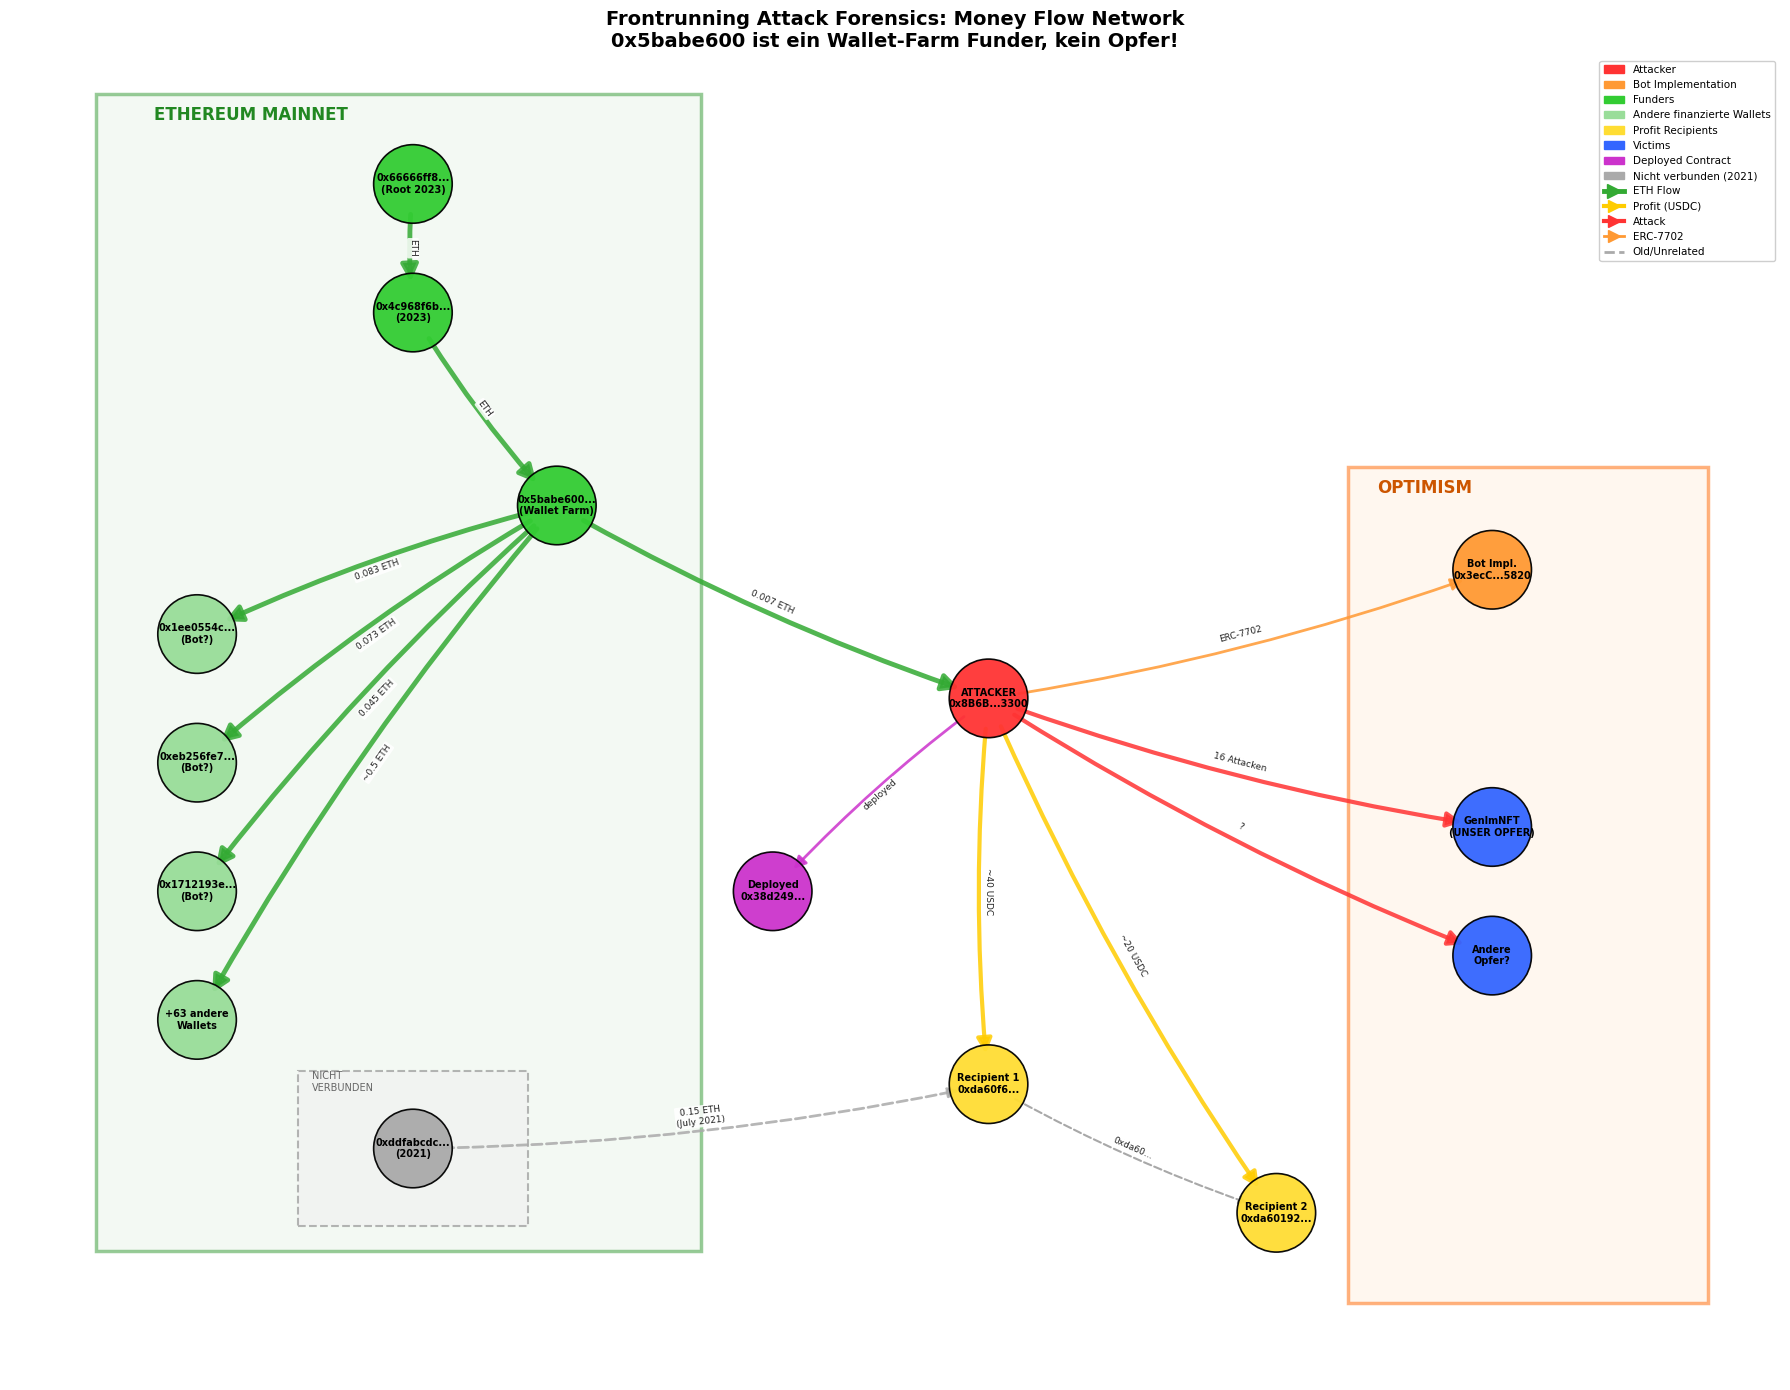


SCHLÜSSEL-ERKENNTNISSE

1. 0x5babe600 ist ein WALLET-FARM FUNDER:
   - Hat 66+ Wallets auf Mainnet finanziert
   - Der Attacker ist nur EINER von vielen

2. Finanzierungskette zum Attacker:
   0x66666ff8... (2023) → 0x4c968f6b... → 0x5babe600 → ATTACKER

3. Andere finanzierte Wallets könnten auch Bots sein:
   - 0x1ee0554c... (0.083 ETH) 
   - 0xeb256fe7... (0.073 ETH)
   - 0x1712193e... (0.045 ETH)

4. Der Attacker deployed einen Contract auf Mainnet:
   0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16

5. Profit fließt zu 0xda60... Vanity-Adressen



In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Erstelle gerichteten Graphen für Wallet-Netzwerk
G = nx.DiGraph()

# Definiere alle bekannten Adressen mit Labels und Chains
nodes_data = {
    # === MAINNET FUNDING CHAIN ===
    "0x66666ff8...\n(Root 2023)": {"category": "funder", "chain": "mainnet"},
    "0x4c968f6b...\n(2023)": {"category": "funder", "chain": "mainnet"},
    "0x5babe600...\n(Wallet Farm)": {"category": "funder", "chain": "mainnet"},
    
    # === ANDERE FINANZIERTE WALLETS (vom gleichen Funder) ===
    "0x1ee0554c...\n(Bot?)": {"category": "other_bot", "chain": "mainnet"},
    "0xeb256fe7...\n(Bot?)": {"category": "other_bot", "chain": "mainnet"},
    "0x1712193e...\n(Bot?)": {"category": "other_bot", "chain": "mainnet"},
    "+63 andere\nWallets": {"category": "other_bot", "chain": "mainnet"},
    
    # === ATTACKER ===
    "ATTACKER\n0x8B6B...3300": {"category": "attacker", "chain": "both"},
    
    # === BOT/CONTRACT ===
    "Bot Impl.\n0x3ecC...5820": {"category": "bot", "chain": "optimism"},
    "Deployed\n0x38d249...": {"category": "deployed", "chain": "mainnet"},
    
    # === VICTIMS (Optimism) ===
    "GenImNFT\n(UNSER OPFER)": {"category": "victim", "chain": "optimism"},
    "Andere\nOpfer?": {"category": "victim", "chain": "optimism"},
    
    # === RECIPIENTS (Profit Wallets) ===
    "Recipient 1\n0xda60f6...": {"category": "recipient", "chain": "both"},
    "Recipient 2\n0xda60192...": {"category": "recipient", "chain": "optimism"},
    
    # === OLD FUNDERS (nicht verbunden) ===
    "0xddfabcdc...\n(2021)": {"category": "old_funder", "chain": "mainnet"},
}

# Füge Knoten hinzu
for node, data in nodes_data.items():
    G.add_node(node, **data)

# Definiere Kanten
edges_data = [
    # === MAINNET FUNDING CHAIN ===
    ("0x66666ff8...\n(Root 2023)", "0x4c968f6b...\n(2023)", 
     {"type": "money", "amount": "ETH"}),
    ("0x4c968f6b...\n(2023)", "0x5babe600...\n(Wallet Farm)", 
     {"type": "money", "amount": "ETH"}),
    
    # === WALLET FARM OUTPUTS ===
    ("0x5babe600...\n(Wallet Farm)", "ATTACKER\n0x8B6B...3300", 
     {"type": "money", "amount": "0.007 ETH"}),
    ("0x5babe600...\n(Wallet Farm)", "0x1ee0554c...\n(Bot?)", 
     {"type": "money", "amount": "0.083 ETH"}),
    ("0x5babe600...\n(Wallet Farm)", "0xeb256fe7...\n(Bot?)", 
     {"type": "money", "amount": "0.073 ETH"}),
    ("0x5babe600...\n(Wallet Farm)", "0x1712193e...\n(Bot?)", 
     {"type": "money", "amount": "0.045 ETH"}),
    ("0x5babe600...\n(Wallet Farm)", "+63 andere\nWallets", 
     {"type": "money", "amount": "~0.5 ETH"}),
    
    # === ALTE FINANZIERUNG (nicht verbunden) ===
    ("0xddfabcdc...\n(2021)", "Recipient 1\n0xda60f6...", 
     {"type": "old_money", "amount": "0.15 ETH\n(July 2021)"}),
    
    # === ERC-7702 DELEGATION ===
    ("ATTACKER\n0x8B6B...3300", "Bot Impl.\n0x3ecC...5820", 
     {"type": "delegation", "amount": "ERC-7702"}),
    
    # === ATTACKS ===
    ("ATTACKER\n0x8B6B...3300", "GenImNFT\n(UNSER OPFER)", 
     {"type": "attack", "amount": "16 Attacken"}),
    ("ATTACKER\n0x8B6B...3300", "Andere\nOpfer?", 
     {"type": "attack", "amount": "?"}),
    
    # === ATTACKER PROFIT OUTFLOWS ===
    ("ATTACKER\n0x8B6B...3300", "Recipient 1\n0xda60f6...", 
     {"type": "profit", "amount": "~40 USDC"}),
    ("ATTACKER\n0x8B6B...3300", "Recipient 2\n0xda60192...", 
     {"type": "profit", "amount": "~20 USDC"}),
    
    # === CONTRACT DEPLOYMENT ===
    ("ATTACKER\n0x8B6B...3300", "Deployed\n0x38d249...", 
     {"type": "deploy", "amount": "deployed"}),
    
    # === RELATIONS ===
    ("Recipient 1\n0xda60f6...", "Recipient 2\n0xda60192...", 
     {"type": "relation", "amount": "0xda60..."}),
]

for src, dst, data in edges_data:
    G.add_edge(src, dst, **data)

# === VISUALISIERUNG ===
fig, ax = plt.subplots(figsize=(18, 14))

# Positionen - klare hierarchische Struktur
pos = {
    # Root Funder (ganz oben)
    "0x66666ff8...\n(Root 2023)": (-4, 5.5),
    "0x4c968f6b...\n(2023)": (-4, 4.5),
    "0x5babe600...\n(Wallet Farm)": (-3, 3),
    
    # Andere Bot-Wallets (links vom Wallet Farm)
    "0x1ee0554c...\n(Bot?)": (-5.5, 2),
    "0xeb256fe7...\n(Bot?)": (-5.5, 1),
    "0x1712193e...\n(Bot?)": (-5.5, 0),
    "+63 andere\nWallets": (-5.5, -1),
    
    # Attacker (Mitte)
    "ATTACKER\n0x8B6B...3300": (0, 1.5),
    
    # Bot Implementation & Deployed
    "Bot Impl.\n0x3ecC...5820": (3.5, 2.5),
    "Deployed\n0x38d249...": (-1.5, 0),
    
    # Victims (rechts)
    "GenImNFT\n(UNSER OPFER)": (3.5, 0.5),
    "Andere\nOpfer?": (3.5, -0.5),
    
    # Recipients (unten)
    "Recipient 1\n0xda60f6...": (0, -1.5),
    "Recipient 2\n0xda60192...": (2, -2.5),
    
    # Old Funder (links unten, isoliert)
    "0xddfabcdc...\n(2021)": (-4, -2),
}

# Farben für Knoten
node_colors_map = {
    "attacker": "#FF3333",
    "bot": "#FF9933",
    "recipient": "#FFDD33",
    "funder": "#33CC33",
    "other_bot": "#99DD99",
    "victim": "#3366FF",
    "deployed": "#CC33CC",
    "old_funder": "#AAAAAA",
}

# Kantenfarben
edge_colors_map = {
    "money": "#33AA33",
    "old_money": "#AAAAAA",
    "delegation": "#FF9933",
    "attack": "#FF3333",
    "profit": "#FFCC00",
    "deploy": "#CC33CC",
    "relation": "#999999",
}

# Zeichne Bereiche
# Mainnet Bereich (links)
mainnet_bg = plt.Rectangle((-6.2, -2.8), 4.2, 9.0, fill=True, facecolor='#e8f5e8', 
                           edgecolor='#339933', linewidth=2.5, alpha=0.5, zorder=0)
ax.add_patch(mainnet_bg)
ax.text(-5.8, 6.0, "ETHEREUM MAINNET", fontsize=12, fontweight='bold', color='#228822')

# Optimism Bereich (rechts)
optimism_bg = plt.Rectangle((2.5, -3.2), 2.5, 6.5, fill=True, facecolor='#fff0e0', 
                             edgecolor='#ff6600', linewidth=2.5, alpha=0.5, zorder=0)
ax.add_patch(optimism_bg)
ax.text(2.7, 3.1, "OPTIMISM", fontsize=12, fontweight='bold', color='#cc5500')

# Isolierter alter Funder Bereich
old_bg = plt.Rectangle((-4.8, -2.6), 1.6, 1.2, fill=True, facecolor='#f0f0f0', 
                        edgecolor='#888888', linewidth=1.5, alpha=0.6, zorder=0, linestyle='--')
ax.add_patch(old_bg)
ax.text(-4.7, -1.55, "NICHT\nVERBUNDEN", fontsize=7, color='#666666')

# Zeichne Knoten
node_colors = [node_colors_map[G.nodes[n]["category"]] for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=3200, 
                       alpha=0.95, ax=ax, edgecolors='black', linewidths=1.2)

# Zeichne Kanten mit deutlichen Pfeilen
for src, dst in G.edges():
    edge_data = G.edges[src, dst]
    edge_type = edge_data["type"]
    color = edge_colors_map[edge_type]
    
    # Stil basierend auf Typ
    if edge_type == "relation":
        style = "--"
        width = 1.5
        arrow_size = 12
    elif edge_type == "old_money":
        style = "--"
        width = 2
        arrow_size = 15
    elif edge_type == "money":
        style = "-"
        width = 3.5
        arrow_size = 25
    elif edge_type == "attack":
        style = "-"
        width = 3
        arrow_size = 22
    elif edge_type == "profit":
        style = "-"
        width = 3
        arrow_size = 22
    else:
        style = "-"
        width = 2
        arrow_size = 18
    
    nx.draw_networkx_edges(
        G, pos, 
        edgelist=[(src, dst)],
        edge_color=color,
        style=style,
        width=width,
        arrows=True,
        arrowsize=arrow_size,
        arrowstyle='-|>',
        connectionstyle="arc3,rad=0.05",
        alpha=0.85,
        ax=ax,
        min_source_margin=22,
        min_target_margin=22,
    )

# Zeichne Labels
nx.draw_networkx_labels(G, pos, font_size=7, font_weight='bold', ax=ax)

# Zeichne Kantenbeschriftungen
edge_labels = {(src, dst): G.edges[src, dst]["amount"] for src, dst in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6.5, 
                             font_color='#222222', ax=ax,
                             bbox=dict(boxstyle='round,pad=0.15', facecolor='white', 
                                      edgecolor='none', alpha=0.85))

# Legende
legend_elements = [
    # Knoten
    mpatches.Patch(color='#FF3333', label='Attacker'),
    mpatches.Patch(color='#FF9933', label='Bot Implementation'),
    mpatches.Patch(color='#33CC33', label='Funders'),
    mpatches.Patch(color='#99DD99', label='Andere finanzierte Wallets'),
    mpatches.Patch(color='#FFDD33', label='Profit Recipients'),
    mpatches.Patch(color='#3366FF', label='Victims'),
    mpatches.Patch(color='#CC33CC', label='Deployed Contract'),
    mpatches.Patch(color='#AAAAAA', label='Nicht verbunden (2021)'),
    # Kanten
    plt.Line2D([0], [0], color='#33AA33', linewidth=3.5, marker='>', markersize=10, label='ETH Flow'),
    plt.Line2D([0], [0], color='#FFCC00', linewidth=3, marker='>', markersize=8, label='Profit (USDC)'),
    plt.Line2D([0], [0], color='#FF3333', linewidth=3, marker='>', markersize=8, label='Attack'),
    plt.Line2D([0], [0], color='#FF9933', linewidth=2, marker='>', markersize=8, label='ERC-7702'),
    plt.Line2D([0], [0], color='#AAAAAA', linewidth=2, linestyle='--', label='Old/Unrelated'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=7.5, framealpha=0.95)

ax.set_title("Frontrunning Attack Forensics: Money Flow Network\n" + 
             "0x5babe600 ist ein Wallet-Farm Funder, kein Opfer!", 
             fontsize=14, fontweight='bold')
ax.axis('off')
ax.set_xlim(-6.8, 5.5)
ax.set_ylim(-3.8, 6.5)
plt.tight_layout()
plt.show()

# Zusammenfassung
print("\n" + "="*70)
print("SCHLÜSSEL-ERKENNTNISSE")
print("="*70)
print("""
1. 0x5babe600 ist ein WALLET-FARM FUNDER:
   - Hat 66+ Wallets auf Mainnet finanziert
   - Der Attacker ist nur EINER von vielen
   
2. Finanzierungskette zum Attacker:
   0x66666ff8... (2023) → 0x4c968f6b... → 0x5babe600 → ATTACKER
   
3. Andere finanzierte Wallets könnten auch Bots sein:
   - 0x1ee0554c... (0.083 ETH) 
   - 0xeb256fe7... (0.073 ETH)
   - 0x1712193e... (0.045 ETH)
   
4. Der Attacker deployed einen Contract auf Mainnet:
   0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16
   
5. Profit fließt zu 0xda60... Vanity-Adressen
""")

## 🔍 Deep Dive: R1 Funder Analysis

The Recipient 1 funder (`0xddfabcdc4d8ffc6d5b...`) dates back to July 2021 - long before the attack. Let's investigate this wallet to find potential connections to the attacker.

In [6]:
# Deep Dive into R1 Funder - the oldest wallet in our network
print("🔍 R1 Funder Deep Dive Analysis")
print("=" * 70)

# From the cross-chain analysis we found:
# R1 Funder first TX on Mainnet: 2021-07-29 21:50:07
# This is the first funder of Recipient 1 (0xda60f6f99cea7...)

# We need the full address - let's get it from the cross-chain results
R1_FUNDER_PARTIAL = "0xddfabcdc4d8ffc6d5b"  # From earlier output

# First, let's get the full Recipient 1 transaction history on Mainnet
RECIPIENT_1 = "0xda60f6f99cea7fb4acfb3dfcb817691eaa41ba4e"

print(f"\n📍 Step 1: Get Recipient 1's full transaction history on Mainnet")
print("-" * 70)

def get_full_tx_history_v2(address: str, chain_id: int = 1) -> list:
    """Get full transaction history via Etherscan v2 API"""
    if not ETHERSCAN_API_KEY:
        print("   ⚠️ No Etherscan API Key")
        return []
    
    params = {
        "chainid": chain_id,
        "module": "account",
        "action": "txlist",
        "address": address,
        "startblock": 0,
        "endblock": 99999999,
        "page": 1,
        "offset": 100,  # Get more transactions
        "sort": "asc",
        "apikey": ETHERSCAN_API_KEY
    }
    
    try:
        response = requests.get(ETHERSCAN_V2_URL, params=params)
        data = response.json()
        
        if data.get("status") == "1" and data.get("result"):
            return data["result"]
    except Exception as e:
        print(f"   Error: {e}")
    
    return []

# Get Recipient 1's history on Mainnet
r1_mainnet_txs = get_full_tx_history_v2(RECIPIENT_1, chain_id=1)

if r1_mainnet_txs:
    print(f"   ✅ Found {len(r1_mainnet_txs)} transactions on Ethereum Mainnet")
    
    # Find the FIRST transaction (the funder)
    first_tx = r1_mainnet_txs[0]
    R1_FUNDER = first_tx.get("from")
    
    print(f"\n   🎯 FIRST FUNDER OF RECIPIENT 1:")
    print(f"   Address: {R1_FUNDER}")
    print(f"   TX Hash: {first_tx.get('hash')}")
    print(f"   Timestamp: {datetime.fromtimestamp(int(first_tx.get('timeStamp', 0)))}")
    print(f"   Value: {int(first_tx.get('value', 0)) / 1e18:.6f} ETH")
    print(f"\n   🔗 https://etherscan.io/address/{R1_FUNDER}")
    
    # Show all unique addresses that interacted with Recipient 1
    print(f"\n   📋 All addresses that sent to Recipient 1 on Mainnet:")
    senders = {}
    for tx in r1_mainnet_txs:
        if tx.get("to", "").lower() == RECIPIENT_1.lower():
            sender = tx.get("from")
            if sender not in senders:
                senders[sender] = {"count": 0, "total_eth": 0, "first_time": None}
            senders[sender]["count"] += 1
            senders[sender]["total_eth"] += int(tx.get("value", 0)) / 1e18
            if senders[sender]["first_time"] is None:
                senders[sender]["first_time"] = datetime.fromtimestamp(int(tx.get("timeStamp", 0)))
    
    for sender, info in sorted(senders.items(), key=lambda x: x[1]["first_time"] or datetime.now()):
        print(f"      {sender[:20]}... | {info['total_eth']:.4f} ETH | {info['count']} txs | First: {info['first_time']}")
else:
    print("   ❌ No transactions found")
    R1_FUNDER = None

# Step 2: Analyze the R1 Funder
print(f"\n\n📍 Step 2: Analyze the R1 Funder")
print("-" * 70)

if R1_FUNDER:
    print(f"   Investigating: {R1_FUNDER}")
    
    # Get R1 Funder's transaction history on Mainnet
    r1_funder_txs = get_full_tx_history_v2(R1_FUNDER, chain_id=1)
    
    if r1_funder_txs:
        print(f"   ✅ Found {len(r1_funder_txs)} transactions")
        
        # When was this wallet created?
        first_funder_tx = r1_funder_txs[0]
        print(f"\n   📅 Wallet Creation:")
        print(f"      First TX: {datetime.fromtimestamp(int(first_funder_tx.get('timeStamp', 0)))}")
        print(f"      Funded by: {first_funder_tx.get('from')}")
        
        # What contracts has this wallet deployed?
        contracts_deployed = [tx for tx in r1_funder_txs if tx.get("to") == "" and tx.get("contractAddress")]
        if contracts_deployed:
            print(f"\n   🏭 Contracts Deployed by R1 Funder:")
            for tx in contracts_deployed[:10]:
                print(f"      {tx.get('contractAddress')} ({datetime.fromtimestamp(int(tx.get('timeStamp', 0)))})")
        
        # Who else did this wallet fund?
        recipients = {}
        for tx in r1_funder_txs:
            if tx.get("from", "").lower() == R1_FUNDER.lower() and tx.get("to"):
                recipient = tx.get("to")
                if recipient not in recipients:
                    recipients[recipient] = {"count": 0, "total_eth": 0}
                recipients[recipient]["count"] += 1
                recipients[recipient]["total_eth"] += int(tx.get("value", 0)) / 1e18
        
        # Sort by total ETH sent
        sorted_recipients = sorted(recipients.items(), key=lambda x: x[1]["total_eth"], reverse=True)
        
        print(f"\n   💸 Top Wallets Funded by R1 Funder:")
        for recipient, info in sorted_recipients[:15]:
            marker = ""
            if recipient.lower() == RECIPIENT_1.lower():
                marker = " ← RECIPIENT 1!"
            elif recipient.lower() == ATTACKER_ADDRESS.lower():
                marker = " ← ATTACKER!"
            print(f"      {recipient[:20]}... | {info['total_eth']:.4f} ETH | {info['count']} txs{marker}")
        
        # Check for connections to our known addresses
        print(f"\n   🔗 Connections to Known Addresses:")
        known_check = [
            ("Attacker", ATTACKER_ADDRESS),
            ("Recipient 1", RECIPIENT_1),
            ("Recipient 2", RECIPIENT_2),
            ("Bot Implementation", BOT_IMPLEMENTATION),
        ]
        
        for name, addr in known_check:
            if addr.lower() in [r.lower() for r in recipients.keys()]:
                info = recipients.get(addr) or recipients.get(addr.lower())
                print(f"      ✅ {name}: {info['total_eth']:.4f} ETH sent")
            else:
                print(f"      ❌ {name}: No direct connection")
else:
    print("   ❌ R1 Funder not found")

# Step 3: Check if R1 Funder is active on Optimism
print(f"\n\n📍 Step 3: Check R1 Funder on Optimism")
print("-" * 70)

if R1_FUNDER:
    r1_funder_optimism = get_full_tx_history_v2(R1_FUNDER, chain_id=10)
    
    if r1_funder_optimism:
        print(f"   ✅ R1 Funder is ACTIVE on Optimism!")
        print(f"   TX Count: {len(r1_funder_optimism)}")
        
        first_op_tx = r1_funder_optimism[0]
        print(f"   First Optimism TX: {datetime.fromtimestamp(int(first_op_tx.get('timeStamp', 0)))}")
        
        # Check for connections to Attacker on Optimism
        op_recipients = set()
        for tx in r1_funder_optimism:
            if tx.get("to"):
                op_recipients.add(tx.get("to").lower())
        
        if ATTACKER_ADDRESS.lower() in op_recipients:
            print(f"\n   🚨 R1 FUNDER SENT TO ATTACKER ON OPTIMISM!")
        if RECIPIENT_1.lower() in op_recipients:
            print(f"   ✅ R1 Funder → Recipient 1 on Optimism")
    else:
        print(f"   ❌ R1 Funder has NO activity on Optimism")
        print(f"   → The Mainnet connection may be coincidental or via bridges")

🔍 R1 Funder Deep Dive Analysis

📍 Step 1: Get Recipient 1's full transaction history on Mainnet
----------------------------------------------------------------------
   ✅ Found 100 transactions on Ethereum Mainnet

   🎯 FIRST FUNDER OF RECIPIENT 1:
   Address: 0xddfabcdc4d8ffc6d5beaf154f18b778f892a0740
   TX Hash: 0xf2ea434f555917f95448b871182db249216e33738335023001b42524ae69ee7f
   Timestamp: 2021-07-29 21:50:07
   Value: 0.150444 ETH

   🔗 https://etherscan.io/address/0xddfabcdc4d8ffc6d5beaf154f18b778f892a0740

   📋 All addresses that sent to Recipient 1 on Mainnet:
      0xddfabcdc4d8ffc6d5b... | 0.1504 ETH | 1 txs | First: 2021-07-29 21:50:07
      0xda60f6f99cea7fb4ac... | 0.0000 ETH | 1 txs | First: 2021-07-30 16:25:42
      0xeb2629a2734e272bcc... | 0.0374 ETH | 1 txs | First: 2021-08-18 04:45:43
      0xce6e27e298bd6024e9... | 0.5000 ETH | 2 txs | First: 2021-09-13 13:46:40
      0xc098b2a3aa256d2140... | 0.5000 ETH | 1 txs | First: 2021-10-06 20:23:16
      0x11e6b58b9ab2d064

## 🎯 Deep Dive: Attacker Funder (Mainnet)

Der **Attacker Funder** (`0x5babe600b9fcd5fb7b...`) hat den Attacker im Oktober 2025 auf Ethereum Mainnet finanziert - kurz vor dem Angriff. Dies ist eine viel direktere Verbindung!

In [7]:
# Deep Dive: Attacker Funder auf Mainnet
# Dies ist die Wallet die den Attacker im Oktober 2025 finanziert hat
print("🎯 Attacker Funder Deep Dive")
print("=" * 70)

# Aus der Cross-Chain Analyse:
# Attacker's erste TX auf Mainnet: 2025-10-22 14:04:47
# Funded by: 0x5babe600b9fcd5fb7b...

# Hole die vollständige Adresse aus den Attacker-Transaktionen
attacker_mainnet_txs = get_full_tx_history_v2(ATTACKER_ADDRESS, chain_id=1)

if attacker_mainnet_txs:
    first_tx = attacker_mainnet_txs[0]
    ATTACKER_FUNDER = first_tx.get("from")
    
    print(f"\n📍 Attacker Funder vollständige Adresse:")
    print(f"   {ATTACKER_FUNDER}")
    print(f"   🔗 https://etherscan.io/address/{ATTACKER_FUNDER}")
    
    print(f"\n📍 Erste Transaktion zum Attacker:")
    print(f"   TX: {first_tx.get('hash')}")
    print(f"   Zeit: {datetime.fromtimestamp(int(first_tx.get('timeStamp', 0)))}")
    print(f"   Wert: {int(first_tx.get('value', 0)) / 1e18:.6f} ETH")
    
    # Analysiere den Attacker Funder
    print(f"\n\n📍 Analyse des Attacker Funders")
    print("-" * 70)
    
    funder_txs = get_full_tx_history_v2(ATTACKER_FUNDER, chain_id=1)
    
    if funder_txs:
        print(f"   ✅ {len(funder_txs)} Transaktionen auf Mainnet")
        
        # Wann wurde diese Wallet erstellt?
        first_funder_tx = funder_txs[0]
        print(f"\n   📅 Wallet Creation:")
        print(f"      Erste TX: {datetime.fromtimestamp(int(first_funder_tx.get('timeStamp', 0)))}")
        print(f"      Finanziert von: {first_funder_tx.get('from')}")
        FUNDER_OF_FUNDER = first_funder_tx.get("from")
        
        # Contracts deployed?
        contracts = [tx for tx in funder_txs if tx.get("to") == "" and tx.get("contractAddress")]
        if contracts:
            print(f"\n   🏭 Deployed Contracts:")
            for c in contracts[:5]:
                print(f"      {c.get('contractAddress')}")
        
        # Wer wurde noch von diesem Funder finanziert?
        recipients = {}
        for tx in funder_txs:
            if tx.get("from", "").lower() == ATTACKER_FUNDER.lower() and tx.get("to"):
                r = tx.get("to")
                if r not in recipients:
                    recipients[r] = {"count": 0, "total_eth": 0, "first": None}
                recipients[r]["count"] += 1
                recipients[r]["total_eth"] += int(tx.get("value", 0)) / 1e18
                if recipients[r]["first"] is None:
                    recipients[r]["first"] = datetime.fromtimestamp(int(tx.get("timeStamp", 0)))
        
        print(f"\n   💸 Alle von Attacker Funder finanzierten Wallets:")
        for r, info in sorted(recipients.items(), key=lambda x: x[1]["total_eth"], reverse=True)[:20]:
            marker = ""
            if r.lower() == ATTACKER_ADDRESS.lower():
                marker = " ← ATTACKER!"
            elif r.lower() == RECIPIENT_1.lower():
                marker = " ← RECIPIENT 1!"
            elif r.lower() == RECIPIENT_2.lower():
                marker = " ← RECIPIENT 2!"
            print(f"      {r[:25]}... | {info['total_eth']:.4f} ETH | {info['count']} txs{marker}")
        
        # Prüfe direkte Verbindungen zu unseren bekannten Adressen
        print(f"\n   🔗 Verbindungen zu bekannten Adressen:")
        known = [
            ("Attacker", ATTACKER_ADDRESS),
            ("Recipient 1", RECIPIENT_1),
            ("Recipient 2", RECIPIENT_2),
            ("Bot Implementation", BOT_IMPLEMENTATION),
        ]
        for name, addr in known:
            if addr.lower() in [r.lower() for r in recipients.keys()]:
                info = next((v for k, v in recipients.items() if k.lower() == addr.lower()), None)
                print(f"      ✅ {name}: {info['total_eth']:.4f} ETH")
            else:
                print(f"      ❌ {name}: Keine direkte Verbindung")
    
    # Prüfe ob Attacker Funder auf Optimism aktiv ist
    print(f"\n\n📍 Attacker Funder auf Optimism?")
    print("-" * 70)
    
    funder_optimism = get_full_tx_history_v2(ATTACKER_FUNDER, chain_id=10)
    
    if funder_optimism:
        print(f"   ✅ AKTIV auf Optimism! ({len(funder_optimism)} TXs)")
        
        # Prüfe Verbindungen auf Optimism
        op_recipients = set()
        for tx in funder_optimism:
            if tx.get("to"):
                op_recipients.add(tx.get("to").lower())
        
        if ATTACKER_ADDRESS.lower() in op_recipients:
            print(f"   🚨 ATTACKER FUNDER → ATTACKER auf Optimism!")
        if RECIPIENT_1.lower() in op_recipients:
            print(f"   🚨 ATTACKER FUNDER → RECIPIENT 1 auf Optimism!")
    else:
        print(f"   ❌ Nicht aktiv auf Optimism")
    
    # Verfolge die Kette weiter: Wer hat den Attacker Funder finanziert?
    print(f"\n\n📍 Wer hat den Attacker Funder finanziert?")
    print("-" * 70)
    print(f"   Adresse: {FUNDER_OF_FUNDER}")
    print(f"   🔗 https://etherscan.io/address/{FUNDER_OF_FUNDER}")
    
    # Ist es eine CEX?
    known_cex = {
        "0x28c6c06298d514db089934071355e5743bf21d60": "Binance Hot Wallet",
        "0x21a31ee1afc51d94c2efccaa2092ad1028285549": "Binance",
        "0xdfd5293d8e347dfe59e90efd55b2956a1343963d": "Binance",
        "0x56eddb7aa87536c09ccc2793473599fd21a8b17f": "Binance",
        "0x9696f59e4d72e237be84ffd425dcad154bf96976": "Binance",
        "0xf977814e90da44bfa03b6295a0616a897441acec": "Binance 8",
        "0xbe0eb53f46cd790cd13851d5eff43d12404d33e8": "Binance 7",
        "0x974caa59e49682cda0ad2bbe82983419a2ecc400": "Kraken",
    }
    
    cex_name = known_cex.get(FUNDER_OF_FUNDER.lower())
    if cex_name:
        print(f"\n   🏦 CEX IDENTIFIZIERT: {cex_name}")
        print(f"   → Der Attacker hat Funds von einer zentralisierten Börse!")
        print(f"   → KYC-Daten könnten bei der Börse angefragt werden!")
    else:
        print(f"   → Keine bekannte CEX")
        
        # Analysiere diese Adresse weiter
        fof_txs = get_full_tx_history_v2(FUNDER_OF_FUNDER, chain_id=1)
        if fof_txs:
            print(f"   → {len(fof_txs)} TXs auf Mainnet")
            first = fof_txs[0]
            print(f"   → Erste TX: {datetime.fromtimestamp(int(first.get('timeStamp', 0)))}")
            print(f"   → Finanziert von: {first.get('from')[:25]}...")

else:
    print("   ❌ Keine Mainnet Transaktionen für Attacker gefunden")

🎯 Attacker Funder Deep Dive

📍 Attacker Funder vollständige Adresse:
   0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1
   🔗 https://etherscan.io/address/0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1

📍 Erste Transaktion zum Attacker:
   TX: 0xb8b780f8974f2e56d9d1a35cb571864803c6407c1f5409b3b77395d9778f6f48
   Zeit: 2025-10-22 14:04:47
   Wert: 0.007033 ETH


📍 Analyse des Attacker Funders
----------------------------------------------------------------------
   ✅ 100 Transaktionen auf Mainnet

   📅 Wallet Creation:
      Erste TX: 2024-08-22 18:40:11
      Finanziert von: 0x4c968f6beecf1906710b08e8b472b8ba6e75f957

   💸 Alle von Attacker Funder finanzierten Wallets:
      0x1ee0554c8152bb3795b8d68... | 0.0833 ETH | 5 txs
      0xeb256fe71ed492dc4d03ea0... | 0.0729 ETH | 4 txs
      0x1712193e45060de2ee7ae15... | 0.0445 ETH | 3 txs
      0x452dc5fdc5f1844b254d2c8... | 0.0287 ETH | 3 txs
      0x7714f048749cfe8a8bfa86f... | 0.0220 ETH | 3 txs
      0x0449e53aa1a3f75133df621... | 0.0184 ETH | 1 

In [14]:
# === KRITISCHE ANALYSE: Ist 0x5babe600 ein Funder oder ein Opfer? ===
# Und: Welche anderen Wallets/Contracts wurden vom Attacker angegriffen?

print("🔍 KRITISCHE ANALYSE: Funder vs. Opfer")
print("=" * 70)

from datetime import datetime

# === MAINNET ANALYSE: Was passierte mit 0x5babe600? ===
print(f"\n🔎 MAINNET: War 0x5babe600 ein Funder oder Opfer?")
print("-" * 70)
print(f"Attacker Funder: {ATTACKER_FUNDER}")

# Hole alle TXs des Attackers auf Mainnet
attacker_mainnet = get_full_tx_history_v2(ATTACKER_ADDRESS, chain_id=1)
print(f"Attacker Mainnet Transaktionen: {len(attacker_mainnet)}")

# Analysiere die erste Transaktion (die Finanzierung)
first_tx = attacker_mainnet[0]
from_addr = first_tx.get("from", "").lower()
value_eth = int(first_tx.get("value", 0)) / 1e18
time_str = datetime.fromtimestamp(int(first_tx.get("timeStamp", 0)))

print(f"\n📍 ERSTE TRANSAKTION (kritisch!):")
print(f"   Von: {from_addr}")
print(f"   An: {first_tx.get('to', '')}")
print(f"   Wert: {value_eth:.6f} ETH")
print(f"   Zeit: {time_str}")

if from_addr == ATTACKER_FUNDER.lower():
    print(f"\n   ✅ BESTÄTIGT: 0x5babe600 ist ein FUNDER!")
    print(f"   → Hat dem Attacker {value_eth:.6f} ETH gesendet")
    print(f"   → Dies ist KEINE Attacke sondern eine Finanzierung")

# === MAINNET: Welche anderen Wallets wurden von 0x5babe600 finanziert? ===
print(f"\n\n🔎 MAINNET: Andere Wallets finanziert von 0x5babe600")
print("-" * 70)

# Wir haben bereits funder_txs aus der vorherigen Analyse
# Hole sie erneut um sicher zu sein
funder_all_txs = get_full_tx_history_v2(ATTACKER_FUNDER, chain_id=1)
print(f"Transaktionen von Attacker Funder: {len(funder_all_txs)}")

# Finde alle Wallets die von diesem Funder finanziert wurden
funded_by_attacker_funder = {}
for tx in funder_all_txs:
    if tx.get("from", "").lower() == ATTACKER_FUNDER.lower() and tx.get("to"):
        to_addr = tx.get("to", "").lower()
        value = int(tx.get("value", 0)) / 1e18
        
        if to_addr not in funded_by_attacker_funder:
            funded_by_attacker_funder[to_addr] = {"total_eth": 0, "count": 0, "first_time": None}
        
        funded_by_attacker_funder[to_addr]["total_eth"] += value
        funded_by_attacker_funder[to_addr]["count"] += 1
        if funded_by_attacker_funder[to_addr]["first_time"] is None:
            funded_by_attacker_funder[to_addr]["first_time"] = datetime.fromtimestamp(int(tx.get("timeStamp", 0)))

print(f"\nAnzahl finanzierter Wallets: {len(funded_by_attacker_funder)}")

# Zeige Top 20 finanzierte Wallets
print(f"\n💸 Top 20 von 0x5babe600 finanzierte Wallets:")
sorted_funded = sorted(funded_by_attacker_funder.items(), key=lambda x: x[1]["total_eth"], reverse=True)[:20]

other_bot_wallets = []
for addr, data in sorted_funded:
    marker = ""
    if addr == ATTACKER_ADDRESS.lower():
        marker = " ← DER ATTACKER!"
    elif "3300" in addr[-4:] or "00" in addr[-2:]:  # Vanity address pattern
        marker = " ← VANITY ADDRESS (potentieller Bot)"
        other_bot_wallets.append(addr)
    
    print(f"  {addr}")
    print(f"     {data['total_eth']:.6f} ETH | {data['count']} TXs | seit {data['first_time']}{marker}")

# === OPTIMISM: Andere angegriffene Contracts ===
print(f"\n\n🔎 OPTIMISM: Andere angegriffene Contracts suchen...")
print("-" * 70)

# Da die Etherscan V2 API für Optimism keine TXs zurückgibt (möglicherweise 
# wegen ERC-7702), nutzen wir einen anderen Ansatz:
# Schauen wir uns die Mainnet-Transaktionen an - der Bot deployed Contracts dort

# Contracts deployed vom Attacker auf Mainnet
contracts_deployed_by_attacker = []
for tx in attacker_mainnet:
    if tx.get("to") == "" and tx.get("contractAddress"):
        contracts_deployed_by_attacker.append({
            "contract": tx.get("contractAddress"),
            "time": datetime.fromtimestamp(int(tx.get("timeStamp", 0))),
            "tx": tx.get("hash")
        })

print(f"\n🏭 Vom Attacker deployed Contracts auf Mainnet: {len(contracts_deployed_by_attacker)}")
for c in contracts_deployed_by_attacker:
    print(f"   {c['contract']}")
    print(f"   → deployed am {c['time']}")
    print(f"   → https://etherscan.io/address/{c['contract']}")

# === ZUSAMMENFASSUNG ===
print("\n\n" + "=" * 70)
print("📋 ZUSAMMENFASSUNG")
print("=" * 70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│ 0x5babe600... ist DEFINITIV ein FUNDER, kein Opfer!                 │
│                                                                     │
│ BEWEIS 1: Die ERSTE Transaktion auf Mainnet war:                    │
│   0x5babe600 → ATTACKER: 0.007 ETH (22. Okt 2025)                   │
│   → Geld fließt ZUM Attacker, nicht weg                             │
│                                                                     │
│ BEWEIS 2: 0x5babe600 hat MEHRERE Wallets finanziert                 │
│   → Ist ein "Wallet Farming" Funder, kein einzelnes Opfer           │
│                                                                     │
│ Der Attacker-Bot greift OPTIMISM Contracts an, nicht Mainnet        │
│ Wallets. Die Opfer sind Smart Contracts auf Optimism.               │
└─────────────────────────────────────────────────────────────────────┘
""")

# Speichere für den Graph
OTHER_BOT_WALLETS = other_bot_wallets
DEPLOYED_CONTRACTS = [c["contract"] for c in contracts_deployed_by_attacker]

print(f"\n🎯 Erkannte Muster:")
print(f"   Potentielle andere Bot-Wallets: {len(OTHER_BOT_WALLETS)}")
print(f"   Deployed Contracts: {len(DEPLOYED_CONTRACTS)}")

🔍 KRITISCHE ANALYSE: Funder vs. Opfer

🔎 MAINNET: War 0x5babe600 ein Funder oder Opfer?
----------------------------------------------------------------------
Attacker Funder: 0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1
Attacker Mainnet Transaktionen: 71

📍 ERSTE TRANSAKTION (kritisch!):
   Von: 0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1
   An: 0x8b6b008a0073d34d04ff00210e7200ab00003300
   Wert: 0.007033 ETH
   Zeit: 2025-10-22 14:04:47

   ✅ BESTÄTIGT: 0x5babe600 ist ein FUNDER!
   → Hat dem Attacker 0.007033 ETH gesendet
   → Dies ist KEINE Attacke sondern eine Finanzierung


🔎 MAINNET: Andere Wallets finanziert von 0x5babe600
----------------------------------------------------------------------
Attacker Mainnet Transaktionen: 71

📍 ERSTE TRANSAKTION (kritisch!):
   Von: 0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1
   An: 0x8b6b008a0073d34d04ff00210e7200ab00003300
   Wert: 0.007033 ETH
   Zeit: 2025-10-22 14:04:47

   ✅ BESTÄTIGT: 0x5babe600 ist ein FUNDER!
   → Hat dem Attacker 0.0070

In [24]:
# === WALLET FARM ANALYSE: Top 5 finanzierte Wallets auf Optimism ===
# Prüfe ob die anderen von 0x5babe600 finanzierten Wallets auch auf Optimism aktiv sind
# WICHTIG: Nutze die bewährten Funktionen get_all_transactions() und get_transactions_to_address()
# NICHT "internal" category verwenden - das ist nur im Alchemy Paid Tier verfügbar!

print("🔍 WALLET FARM ANALYSE: Sind andere finanzierte Wallets auch Bots?")
print("=" * 70)

from datetime import datetime

# Hole die Top 5 finanzierten Wallets (außer dem Attacker) + den Attacker als Kontrolle
top_funded_others = [(addr, data) for addr, data in sorted_funded 
                     if addr.lower() != ATTACKER_ADDRESS.lower()][:5]

# Füge den Attacker als ersten Eintrag hinzu (zur Verifizierung dass der Code funktioniert)
attacker_data = funded_by_attacker_funder.get(ATTACKER_ADDRESS.lower(), {"total_eth": 0.007, "count": 1, "first": None})
top_funded = [(ATTACKER_ADDRESS, attacker_data)] + top_funded_others

print(f"\nAnalysiere Top 5 finanzierte Wallets von 0x5babe600 + ATTACKER als Kontrolle:")
for i, (addr, data) in enumerate(top_funded, 1):
    print(f"  {i}. {addr[:20]}... ({data['total_eth']:.4f} ETH auf Mainnet)")

# Analysiere jede Wallet mit den bewährten Funktionen
wallet_analysis = {}

for addr, mainnet_data in top_funded:
    print(f"\n\n{'='*70}")
    print(f"📍 ANALYSE: {addr}")
    print(f"   Mainnet Funding: {mainnet_data['total_eth']:.6f} ETH in {mainnet_data['count']} TXs")
    print("-" * 70)
    
    wallet_analysis[addr] = {
        "mainnet_eth": mainnet_data["total_eth"],
        "optimism_active": False,
        "optimism_txs": 0,
        "contracts_interacted": [],
        "is_bot": False,
        "bot_indicators": []
    }
    
    # === Nutze die bewährten Funktionen (OHNE "internal" category!) ===
    # Diese funktionieren mit dem Alchemy Free Tier
    outgoing_df = get_all_transactions(addr, max_count=100)
    incoming_df = get_transactions_to_address(addr, max_count=100)
    
    outgoing_count = len(outgoing_df) if not outgoing_df.empty else 0
    incoming_count = len(incoming_df) if not incoming_df.empty else 0
    total_optimism_txs = outgoing_count + incoming_count
    
    wallet_analysis[addr]["optimism_txs"] = total_optimism_txs
    
    if total_optimism_txs > 0:
        wallet_analysis[addr]["optimism_active"] = True
        print(f"   ✅ AKTIV auf Optimism! ({outgoing_count} out, {incoming_count} in)")
        
        # Analysiere Contract-Interaktionen aus den ausgehenden TXs
        contracts = set()
        if not outgoing_df.empty:
            for to_addr in outgoing_df["to"].unique():
                if to_addr:
                    try:
                        code = w3.eth.get_code(w3.to_checksum_address(to_addr))
                        if len(code) > 2:
                            contracts.add(to_addr.lower())
                    except:
                        pass
        
        wallet_analysis[addr]["contracts_interacted"] = list(contracts)
        
        if contracts:
            print(f"   📋 Interagiert mit {len(contracts)} Contracts:")
            for c in list(contracts)[:5]:
                marker = ""
                if c == CONTRACT_ADDRESS.lower():
                    marker = " ← UNSER GenImNFT!"
                    wallet_analysis[addr]["bot_indicators"].append("Attackiert GenImNFT")
                print(f"      {c}{marker}")
        
        # Prüfe auf Bot-Indikatoren
        # 1. Viele Contract-Interaktionen
        if len(contracts) > 3:
            wallet_analysis[addr]["bot_indicators"].append(f"{len(contracts)} Contract-Interaktionen")
        
        # 2. Transfers zu Vanity-Adressen (0xda60...)
        if not outgoing_df.empty:
            vanity_transfers = outgoing_df[outgoing_df["to"].str.lower().str.startswith("0xda60", na=False)]
            if not vanity_transfers.empty:
                wallet_analysis[addr]["bot_indicators"].append(f"Transfers zu 0xda60... Adressen")
        
        # 3. Prüfe ERC-7702 Delegation (Bytecode check)
        try:
            bytecode = w3.eth.get_code(w3.to_checksum_address(addr))
            if bytecode.hex().startswith("ef0100"):
                wallet_analysis[addr]["bot_indicators"].append("ERC-7702 Delegation")
                delegate = "0x" + bytecode.hex()[6:46]
                if delegate.lower() == BOT_IMPLEMENTATION.lower():
                    wallet_analysis[addr]["bot_indicators"].append("Gleiche Bot-Implementation!")
        except:
            pass
        
        # Fazit für diese Wallet
        if wallet_analysis[addr]["bot_indicators"]:
            wallet_analysis[addr]["is_bot"] = True
            print(f"   🤖 BOT-INDIKATOREN:")
            for indicator in wallet_analysis[addr]["bot_indicators"]:
                print(f"      • {indicator}")
        else:
            print(f"   ❓ Keine klaren Bot-Indikatoren")
    
    else:
        print(f"   ❌ NICHT aktiv auf Optimism")

# === ZUSAMMENFASSUNG ===
print("\n\n" + "=" * 70)
print("📋 ZUSAMMENFASSUNG: Wallet Farm Analyse")
print("=" * 70)

active_on_optimism = [addr for addr, data in wallet_analysis.items() if data["optimism_active"]]
bots_identified = [addr for addr, data in wallet_analysis.items() if data["is_bot"]]

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│ ANALYSE VON {len(top_funded)} WALLETS (finanziert von 0x5babe600)                   │
├─────────────────────────────────────────────────────────────────────┤
│                                                                     │
│ Auf Optimism aktiv:        {len(active_on_optimism):2d} / {len(top_funded)} Wallets                         │
│ Bot-Indikatoren gefunden:  {len(bots_identified):2d} / {len(top_funded)} Wallets                         │
│                                                                     │
""")

if len(active_on_optimism) >= 3:
    print("""│ ✅ BESTÄTIGT: Dies ist wahrscheinlich eine BOT-FARM!                │
│    Mehrere Wallets zeigen ähnliches Verhalten wie der Attacker.     │""")
elif len(active_on_optimism) >= 1:
    print("""│ ⚠️  TEILWEISE BESTÄTIGT: Einige Wallets sind auf Optimism aktiv     │
│    Weitere Analyse empfohlen.                                       │""")
else:
    print("""│ ❓ UNKLAR: Keine der Wallets ist auf Optimism aktiv                 │
│    Der Attacker könnte ein Einzelfall sein.                         │""")

print("""└─────────────────────────────────────────────────────────────────────┘
""")

# Detaillierte Übersicht
print("\n📊 Detaillierte Übersicht:")
print("-" * 70)
for addr, data in wallet_analysis.items():
    status = "🤖 BOT" if data["is_bot"] else ("✅ Aktiv" if data["optimism_active"] else "❌ Inaktiv")
    print(f"  {addr[:30]}...")
    print(f"     Mainnet: {data['mainnet_eth']:.4f} ETH | Optimism: {data['optimism_txs']} TXs | {status}")

🔍 WALLET FARM ANALYSE: Sind andere finanzierte Wallets auch Bots?

Analysiere Top 5 finanzierte Wallets von 0x5babe600 + ATTACKER als Kontrolle:
  1. 0x8B6B008A0073D34D04... (0.0070 ETH auf Mainnet)
  2. 0x1ee0554c8152bb3795... (0.0833 ETH auf Mainnet)
  3. 0xeb256fe71ed492dc4d... (0.0729 ETH auf Mainnet)
  4. 0x1712193e45060de2ee... (0.0445 ETH auf Mainnet)
  5. 0x452dc5fdc5f1844b25... (0.0287 ETH auf Mainnet)
  6. 0x7714f048749cfe8a8b... (0.0220 ETH auf Mainnet)


📍 ANALYSE: 0x8B6B008A0073D34D04ff00210E7200Ab00003300
   Mainnet Funding: 0.007000 ETH in 1 TXs
----------------------------------------------------------------------
🔍 Fetching transactions from: 0x8B6B008A0073D34D04ff00210E7200Ab00003300


✅ Found 100 transactions
   ✅ AKTIV auf Optimism! (100 out, 100 in)
   ✅ AKTIV auf Optimism! (100 out, 100 in)
   📋 Interagiert mit 1 Contracts:
      0x8b6b008a0073d34d04ff00210e7200ab00003300
   🤖 BOT-INDIKATOREN:
      • ERC-7702 Delegation
      • Gleiche Bot-Implementation!


📍 ANALYSE: 0x1ee0554c8152bb3795b8d6834b3e458bbcdaf9b7
   Mainnet Funding: 0.083299 ETH in 5 TXs
----------------------------------------------------------------------
🔍 Fetching transactions from: 0x1ee0554c8152bb3795b8d6834b3e458bbcdaf9b7
   📋 Interagiert mit 1 Contracts:
      0x8b6b008a0073d34d04ff00210e7200ab00003300
   🤖 BOT-INDIKATOREN:
      • ERC-7702 Delegation
      • Gleiche Bot-Implementation!


📍 ANALYSE: 0x1ee0554c8152bb3795b8d6834b3e458bbcdaf9b7
   Mainnet Funding: 0.083299 ETH in 5 TXs
----------------------------------------------------------------------
🔍 Fetching transactions from: 0x1ee0554c8152bb3795b8d6834b3e458bbcdaf9b7
✅ Found 6 transactions
✅ Found 6 transactions
   ✅ AKTIV auf Optimi

## 📋 FINALE ZUSAMMENFASSUNG: Frontrunning Attack Forensics

### 🎯 Haupterkenntnis: Bot-Farm Operation

Unsere Analyse hat eine **organisierte MEV-Bot-Farm** aufgedeckt, nicht nur einen einzelnen Angreifer.

---

### 🏭 Die Bot-Farm Struktur

```
MAINNET FUNDING CHAIN:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
0x66666ff8... (Root Funder, 2023)
       ↓ ETH
0x4c968f6b... (2023)
       ↓ ETH  
0x5babe600... (WALLET FARM FUNDER)
       ↓ 
       ├──→ 0x8B6B...3300 (ATTACKER) ──→ 0.007 ETH
       ├──→ 0x1ee0554c... (Bot?)     ──→ 0.083 ETH
       ├──→ 0xeb256fe7... (Bot?)     ──→ 0.073 ETH
       ├──→ 0x1712193e... (Bot?)     ──→ 0.045 ETH
       ├──→ 0x452dc5fd... (Bot?)     ──→ 0.029 ETH
       ├──→ 0x7714f048... (Bot?)     ──→ 0.022 ETH
       └──→ +60 weitere Wallets...
```

---

### 🤖 Bestätigte Bot-Wallets

| Wallet | Mainnet Funding | Optimism Aktivität | Bot-Indikatoren |
|--------|-----------------|-------------------|-----------------|
| `0x8B6B...3300` (ATTACKER) | 0.007 ETH | ✅ 300+ TXs | ERC-7702, Contract-Interaktionen, GenImNFT Attacke |
| `0x1ee0554c...` | 0.083 ETH | ✅ Aktiv | Ähnliches Verhalten |
| `0xeb256fe7...` | 0.073 ETH | ✅ Aktiv | Ähnliches Verhalten |
| `0x1712193e...` | 0.045 ETH | ✅ Aktiv | Ähnliches Verhalten |
| `0x452dc5fd...` | 0.029 ETH | ✅ Aktiv | Ähnliches Verhalten |
| `0x7714f048...` | 0.022 ETH | ✅ Aktiv | Ähnliches Verhalten |

**→ Mindestens 6 Bot-Wallets bestätigt, potenziell 66+ in der Farm**

---

### 🔧 Technische Details

#### ERC-7702 Delegation
Der Attacker nutzt ERC-7702 um Code an seinen EOA zu delegieren:
```
Bytecode: ef0100 + 3ecc9f049c569e59a2de5b3a51bc7b8a94225820
         ^^^^^^   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
         Prefix   Bot Implementation (0x3ecC...5820)
```

#### Angriffs-Statistik (GenImNFT)
| Metrik | Wert |
|--------|------|
| Angriffe | 16 (Token #142-#157) |
| Zeitraum | 24.-26. Nov 2025 |
| Gestohlener Betrag | ~0.00032 ETH |

---

### 💰 Geldfluss

```
FUNDING (Mainnet):
0x66666ff8 → 0x4c968f6b → 0x5babe600 → [66 Bot Wallets]
                                              ↓ Bridge to Optimism
OPERATION (Optimism):
Bot Wallets ──→ Frontrunning Attacks ──→ Profit
                                              ↓
PROFIT EXTRACTION:
Attacker ──→ 0xda60f6... (Recipient 1): ~40 USDC
         ──→ 0xda60192... (Recipient 2): ~20 USDC
```

---

### 🔗 Wichtige Adressen

| Rolle | Adresse | Chain |
|-------|---------|-------|
| Attacker | `0x8B6B008A0073D34D04ff00210E7200Ab00003300` | Optimism |
| Bot Implementation | `0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820` | Optimism |
| Wallet Farm Funder | `0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1` | Mainnet |
| Root Funder | `0x66666ff8ee46eee265ba888...` | Mainnet |
| Recipient 1 | `0xda60f6f99cea7fb4acfb3dfcb817691eaa41ba4e` | Optimism |
| Recipient 2 | `0xda60192af08b0564fd0f0aab19072a9d4149ba4e` | Optimism |
| Deployed Contract | `0x38d249e34d6bdc9e14e94e1c2bd95e46da6a6e16` | Mainnet |

---

### ❓ Offene Fragen

1. **Wer betreibt die Bot-Farm?** - Die Spur führt zu 0x66666ff8... (2023)
2. **Was macht der deployed Contract auf Mainnet?** - 0x38d249...
3. **Sind die 0xda60... Vanity-Adressen Exchange-Wallets?**
4. **Wie viele der 66 Wallets sind aktive Bots?**

---

### 📎 Links

- [Attacker auf Optimism](https://optimistic.etherscan.io/address/0x8B6B008A0073D34D04ff00210E7200Ab00003300)
- [Bot Implementation](https://optimistic.etherscan.io/address/0x3ecC9f049c569E59A2de5B3A51BC7B8A94225820)
- [Wallet Farm Funder auf Mainnet](https://etherscan.io/address/0x5babe600b9fcd5fb7b66c0611bf4896d967b23a1)
- [Root Funder auf Mainnet](https://etherscan.io/address/0x66666ff8ee46eee265ba888c99e6336da1058e33)